In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from google.cloud import bigquery
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2025-06-03 16:24:18.358549: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-03 16:24:18.362018: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-03 16:24:18.377963: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-03 16:24:18.413718: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748964258.448161  169599 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748964258.45

In [3]:
from tensorflow.keras import callbacks
from tensorflow.keras import Sequential, Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
def get_data_from_bq(
        gcp_project:str,
        query:str,
        data_has_header=True
    ) -> pd.DataFrame:
    """
    Retrieve `query` data from BigQuery
    """
    client = bigquery.Client(project=gcp_project)
    query_job = client.query(query)
    result = query_job.result()
    df = result.to_dataframe()
    df = df.astype("float64")
    return df

In [5]:
GCP_PROJECT = "skin-scan-461716"
BQ_DATASET = "skin_scan"

In [6]:
query = f"""
        SELECT *
        FROM `{GCP_PROJECT}`.{BQ_DATASET}.train_28x28
    """

In [7]:
data = get_data_from_bq(f"{GCP_PROJECT}", query)

In [8]:
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,179.0,138.0,169.0,180.0,137.0,169.0,182.0,139.0,169.0,186.0,...,189.0,161.0,192.0,189.0,161.0,189.0,187.0,157.0,183.0,4.0
1,139.0,74.0,78.0,148.0,80.0,85.0,160.0,91.0,99.0,170.0,...,9.0,8.0,8.0,15.0,14.0,16.0,21.0,18.0,22.0,4.0
2,65.0,41.0,57.0,130.0,95.0,115.0,173.0,136.0,161.0,187.0,...,20.0,9.0,18.0,19.0,10.0,19.0,17.0,10.0,17.0,4.0
3,201.0,159.0,176.0,207.0,155.0,174.0,207.0,150.0,163.0,207.0,...,83.0,86.0,138.0,104.0,101.0,161.0,117.0,102.0,156.0,6.0
4,229.0,188.0,208.0,237.0,191.0,216.0,235.0,179.0,195.0,233.0,...,106.0,105.0,168.0,131.0,122.0,193.0,142.0,121.0,184.0,6.0


In [9]:
X = data.drop(columns="label")

In [10]:
X = X/255

In [11]:
y = data["label"]

In [12]:
X.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351
0,0.701961,0.541176,0.662745,0.705882,0.537255,0.662745,0.713725,0.545098,0.662745,0.729412,...,0.737255,0.741176,0.631373,0.752941,0.741176,0.631373,0.741176,0.733333,0.615686,0.717647
1,0.545098,0.290196,0.305882,0.580392,0.313725,0.333333,0.627451,0.356863,0.388235,0.666667,...,0.070588,0.035294,0.031373,0.031373,0.058824,0.054902,0.062745,0.082353,0.070588,0.086275
2,0.254902,0.160784,0.223529,0.509804,0.372549,0.450980,0.678431,0.533333,0.631373,0.733333,...,0.086275,0.078431,0.035294,0.070588,0.074510,0.039216,0.074510,0.066667,0.039216,0.066667
3,0.788235,0.623529,0.690196,0.811765,0.607843,0.682353,0.811765,0.588235,0.639216,0.811765,...,0.392157,0.325490,0.337255,0.541176,0.407843,0.396078,0.631373,0.458824,0.400000,0.611765
4,0.898039,0.737255,0.815686,0.929412,0.749020,0.847059,0.921569,0.701961,0.764706,0.913725,...,0.458824,0.415686,0.411765,0.658824,0.513725,0.478431,0.756863,0.556863,0.474510,0.721569


In [13]:
round(y.value_counts(ascending=False,normalize=True)*100,1)

label
4.0    66.9
6.0    11.1
2.0    11.0
1.0     5.1
0.0     3.3
5.0     1.4
3.0     1.1
Name: proportion, dtype: float64

In [14]:
X.dtypes

pixel0000    float64
pixel0001    float64
pixel0002    float64
pixel0003    float64
pixel0004    float64
              ...   
pixel2347    float64
pixel2348    float64
pixel2349    float64
pixel2350    float64
pixel2351    float64
Length: 2352, dtype: object

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

In [16]:
X_train.shape

(7010, 2352)

In [17]:
X_train = np.array(X_train)
X_train

array([[0.59215686, 0.47843137, 0.4745098 , ..., 0.55686275, 0.43137255,
        0.42745098],
       [0.53333333, 0.39215686, 0.47843137, ..., 0.51764706, 0.36470588,
        0.4627451 ],
       [0.50980392, 0.43137255, 0.49019608, ..., 0.03921569, 0.01960784,
        0.03529412],
       ...,
       [0.79215686, 0.43529412, 0.48627451, ..., 0.79215686, 0.52156863,
        0.48235294],
       [0.81176471, 0.6745098 , 0.69803922, ..., 0.80392157, 0.70980392,
        0.73333333],
       [0.86666667, 0.67843137, 0.80784314, ..., 0.85098039, 0.68627451,
        0.89411765]])

In [18]:
X_test = np.array(X_test)
X_test

array([[0.85098039, 0.55294118, 0.56862745, ..., 0.79215686, 0.55686275,
        0.55686275],
       [0.77647059, 0.38823529, 0.47843137, ..., 0.74117647, 0.39215686,
        0.45098039],
       [0.52941176, 0.36078431, 0.29803922, ..., 0.43137255, 0.30196078,
        0.25098039],
       ...,
       [0.82745098, 0.62745098, 0.52941176, ..., 0.8627451 , 0.6627451 ,
        0.5254902 ],
       [0.53333333, 0.38823529, 0.37647059, ..., 0.59215686, 0.48235294,
        0.52156863],
       [0.85490196, 0.75294118, 0.78039216, ..., 0.00392157, 0.        ,
        0.00392157]])

In [19]:
X_train = X_train.reshape(-1,28,28,3)
X_test = X_test.reshape(-1,28,28,3)

In [20]:
X_train.shape

(7010, 28, 28, 3)

In [21]:
X_test.shape

(3005, 28, 28, 3)

In [22]:
y_train

2012    0.0
601     2.0
2602    6.0
5297    1.0
2384    6.0
       ... 
828     4.0
9764    4.0
7926    4.0
4301    2.0
3743    4.0
Name: label, Length: 7010, dtype: float64

In [23]:
from keras.utils import to_categorical

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [24]:
y_train

2012    0.0
601     2.0
2602    6.0
5297    1.0
2384    6.0
       ... 
828     4.0
9764    4.0
7926    4.0
4301    2.0
3743    4.0
Name: label, Length: 7010, dtype: float64

In [25]:
y_train_cat

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [26]:
y_train_cat.shape

(7010, 7)

In [27]:
model = Sequential()

model.add(Input(shape=(28, 28, 3)))
model.add(layers.Conv2D(16, (6, 6), padding='same', activation="relu"))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(layers.Flatten())
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

E0000 00:00:1748964276.147894  169599 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1748964276.148330  169599 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │         1,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │       501,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 508,311 (1.94 MB)

 Trainable params: 508,311 (1.94 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=["accuracy","recall"])

In [30]:
es = EarlyStopping(patience=10, restore_best_weights=True)

In [31]:
history = model.fit(X_train, y_train_cat,
          epochs=100,  # Use early stopping in practice
          batch_size=32,
          verbose=2,
          validation_split = 0.2,
          callbacks=[es])

Epoch 1/100
176/176 - 3s - 16ms/step - accuracy: 0.6699 - loss: 1.0314 - recall: 0.5562 - val_accuracy: 0.6762 - val_loss: 1.0593 - val_recall: 0.6427
Epoch 2/100
176/176 - 1s - 8ms/step - accuracy: 0.6799 - loss: 0.9379 - recall: 0.5644 - val_accuracy: 0.6805 - val_loss: 0.9664 - val_recall: 0.5143
Epoch 3/100
176/176 - 1s - 7ms/step - accuracy: 0.6849 - loss: 0.8934 - recall: 0.5811 - val_accuracy: 0.6712 - val_loss: 0.9246 - val_recall: 0.6006
Epoch 4/100
176/176 - 3s - 15ms/step - accuracy: 0.6904 - loss: 0.8595 - recall: 0.5913 - val_accuracy: 0.6954 - val_loss: 0.9167 - val_recall: 0.5756
Epoch 5/100
176/176 - 1s - 8ms/step - accuracy: 0.6979 - loss: 0.8375 - recall: 0.5940 - val_accuracy: 0.6805 - val_loss: 0.8848 - val_recall: 0.6148
Epoch 6/100
176/176 - 1s - 7ms/step - accuracy: 0.6942 - loss: 0.8383 - recall: 0.5931 - val_accuracy: 0.6833 - val_loss: 0.8747 - val_recall: 0.6070
Epoch 7/100
176/176 - 1s - 7ms/step - accuracy: 0.7126 - loss: 0.7860 - recall: 0.6164 - val_accur

In [32]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))

    # --- LOSS ---

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- ACCURACY

    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

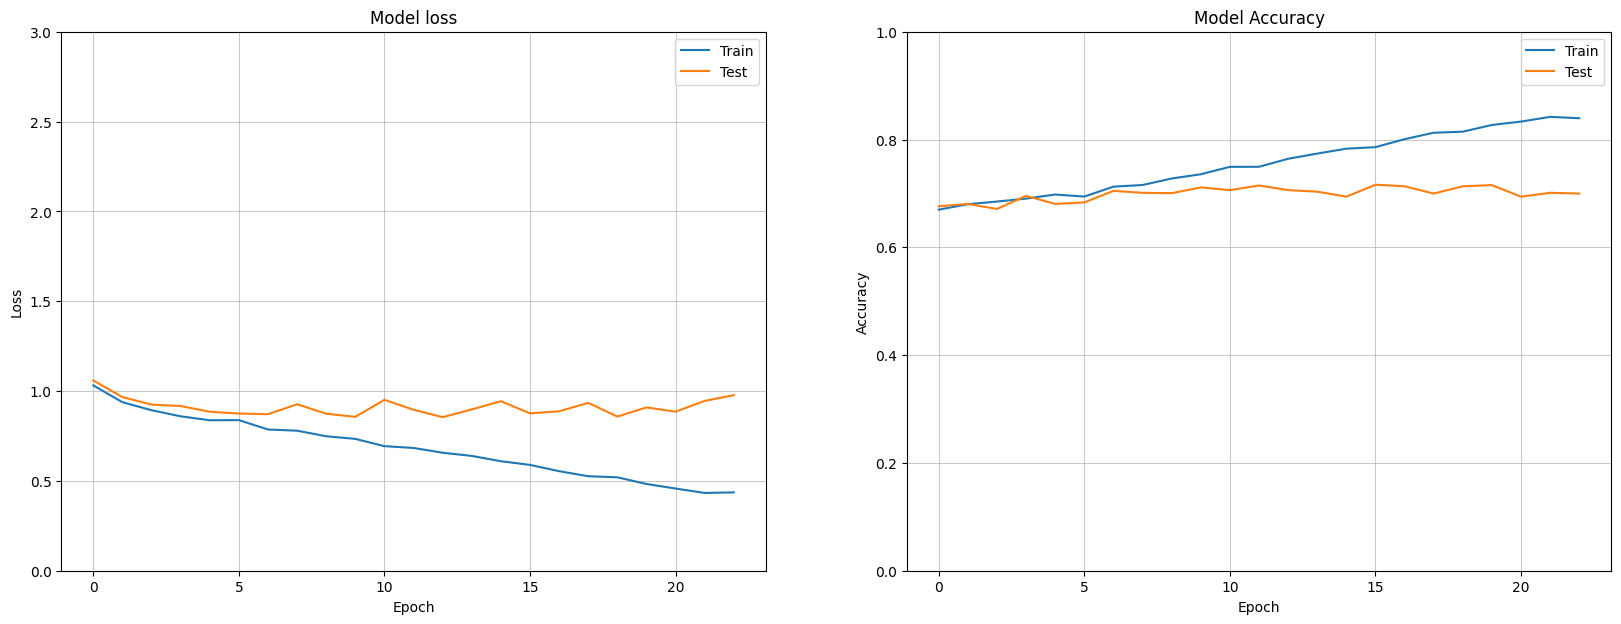

In [33]:
plot_loss_accuracy(history)

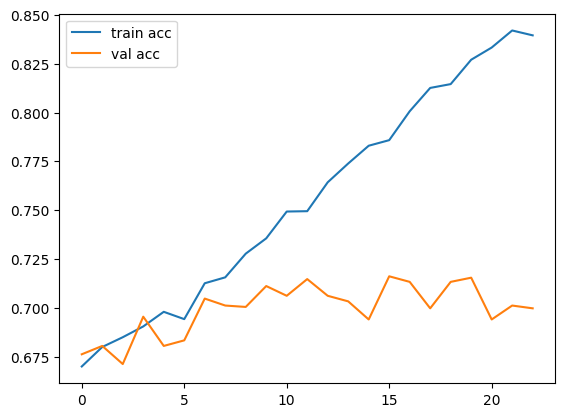

In [34]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [41]:
np.max(history.history["val_accuracy"])

np.float64(0.7161198258399963)

In [36]:
model.evaluate(X_test,y_test_cat)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7108 - loss: 0.8305 - recall: 0.6430


[0.8280095458030701, 0.7064892053604126, 0.6459234356880188]

In [37]:
model.metrics_names

['loss', 'compile_metrics']

In [38]:
pd.DataFrame(history.history)

,accuracy,loss,recall,val_accuracy,val_loss,val_recall
0,0.669936,1.031449,0.556170,0.676177,1.059337,0.642653
1,0.679922,0.937934,0.564372,0.680457,0.966420,0.514265
2,0.684914,0.893391,0.581134,0.671184,0.924577,0.600571
3,0.690442,0.859458,0.591298,0.695435,0.916743,0.575606
4,0.697932,0.837533,0.593973,0.680457,0.884780,0.614836
5,0.694187,0.838261,0.593081,0.683310,0.874676,0.606990
6,0.712554,0.786030,0.616441,0.704708,0.871288,0.592011
7,0.715585,0.779386,0.614123,0.701141,0.926522,0.639800
8,0.727710,0.748348,0.628566,0.700428,0.873825,0.631241
9,0.735556,0.733790,0.639087,0.711127,0.856503,0.628388
